In [1]:
import os

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm.notebook import tqdm

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
from torch.nn import functional as F

from aegear.model import ConvClassifier

In [2]:
# 3. Download the data if not already in place
dataset_dir = "../data/training"
dataset_units = [
    "fish",
    "background",
    "training.json"
]

# Check if the dataset directory exists
os.makedirs(dataset_dir, exist_ok=True)

# Check if each of the dataset units is present
units_exist = [os.path.exists(os.path.join(dataset_dir, unit)) for unit in dataset_units]
if not all(units_exist):
    import gdown
    import zipfile
    print("Downloading dataset...")
    # Google Drive share link
    file_id = "1hl__m48gNDHtlWQ5Se73U5Dw_8Qwsl6Z"
    url = f'https://drive.google.com/uc?id={file_id}'

    output = os.path.join(dataset_dir, 'downloaded.zip')
    gdown.download(url, output, quiet=False)

    # Unzip
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)


In [3]:
# Define the image transformations: resize to the same size, convert to tensor, and normalize pixel values
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),  # Random rotation
        transforms.CenterCrop((ConvClassifier.ROI_SIZE, ConvClassifier.ROI_SIZE)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )  # Normalize to ImageNet mean and standard deviation
])

dataset = datasets.ImageFolder(dataset_dir, transform=transform)

# Split your dataset into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
batch_size = 32

# Create DataLoaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")

Training set size: 2251
Validation set size: 251


In [4]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

model = ConvClassifier()
model.to(device)

criterion = nn.BCELoss()

# Define your optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)

# Define your scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

Using device: mps


Training:   0%|          | 0/100 [00:00<?, ?it/s]

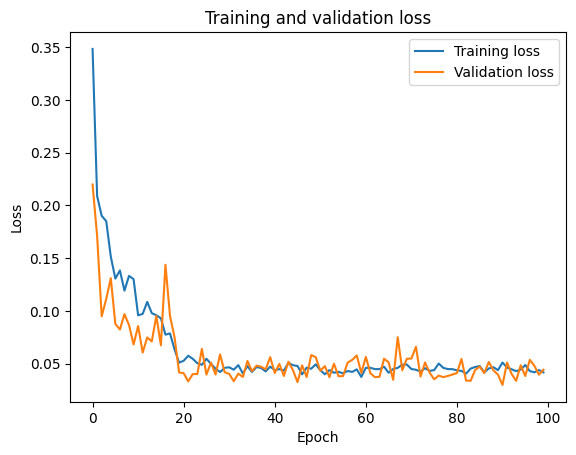

In [5]:
# number of epochs to train the model
num_epochs = 100
model_dir = "../data/models/cnnclassifier"

os.makedirs(model_dir, exist_ok=True)

# Initialize lists to store losses for each epoch
train_losses = []
val_losses = []

best_val_loss = float('inf')  # Initialize the best validation loss to infinity

pbar = tqdm(range(num_epochs), desc="Training")

for epoch in pbar:
    # Initialize variables to store the total loss in this epoch
    train_loss = 0.0
    val_loss = 0.0

    # Training loop
    model.train()  # Set the model to training mode
    for images, labels in train_loader:

        # Move the training data to the GPU
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float().view_as(outputs))
        loss.backward()
        optimizer.step()

        # Add this batch's loss to the total loss for this epoch
        train_loss += loss.item()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels.float().view_as(outputs))

            # Add this batch's loss to the total loss for this epoch
            val_loss += loss.item()

    # Divide the total loss by the number of batches to get the average loss for this epoch
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    # Check if the validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"{model_dir}/best_model.pth")

    # Add the average losses for this epoch to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    pbar.set_description(f"Epoch {epoch+1}/{num_epochs}: train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")

    # Update the learning rate
    scheduler.step(val_loss)

# Plot the training and validation loss
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Load the best model
model.load_state_dict(torch.load(f"{model_dir}/best_model.pth"))

<All keys matched successfully>

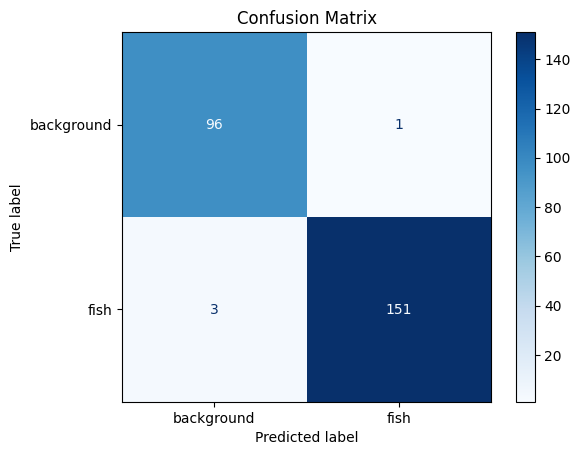

In [7]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs).squeeze(1)  # already passed through sigmoid
        preds = (outputs > 0.8).long()      # threshold to get binary class

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

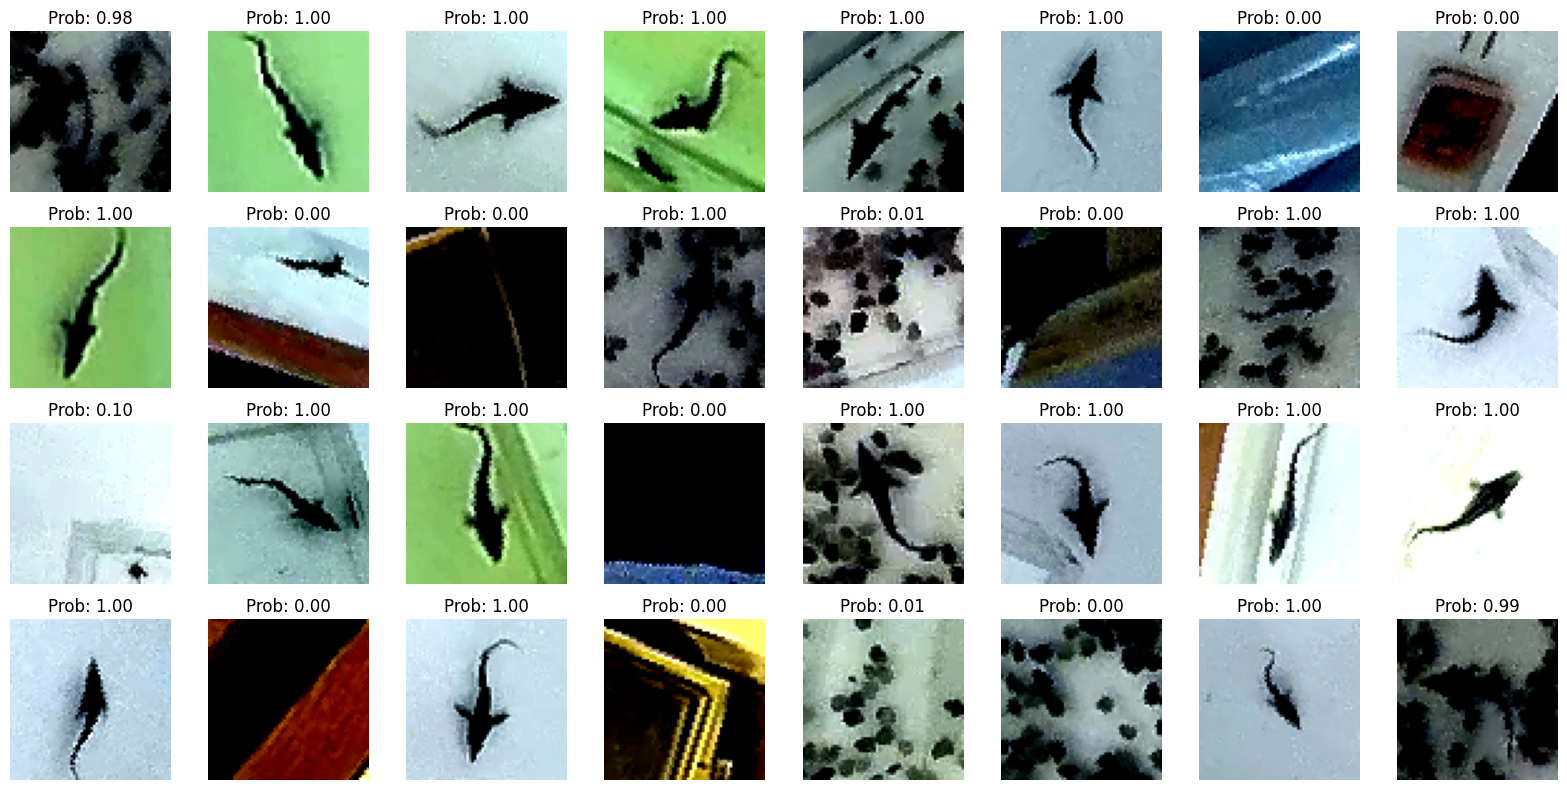

In [8]:
# display a grid of validation data using matplotlib
images, labels = next(iter(val_loader))

# shuffle images and labels
idx = torch.randperm(images.shape[0])
images = images[idx]
images = images[idx]

# take only 32 images
images = images[:32].to(device)
labels = labels[:32].to(device)

outputs = model(images)
outputs = outputs.squeeze(1).detach().cpu().numpy()  # Convert tensor to numpy array
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))

for idx, image in enumerate(images):
    # renormalize the image to [0-1]
    image = torch.clip(image / 2 + 0.5, 0, 1)

    ax = axes.flatten()[idx]
    ax.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')

    ax.set_title(f"Prob: {outputs[idx]:.2f}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()